In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("No GPU found")

In [5]:
import myplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

myplotlib.load("hershey")

In [65]:
class Simulation:
    def __init__(self, nx, engine, **kwargs):
        self.nx = nx
        self.emin = kwargs.get("emin", 1e-4)
        self.emax = kwargs.get("emax", 10)
        self.xmin = np.log(self.emin)
        self.xmax = np.log(self.emax)
        self.Te = kwargs.get("Te", 1e-1)
        self.T0 = kwargs.get("T0", 0.001)
        self.dt = kwargs.get("dt", 0.001)
        self.dx = (self.xmax - self.xmin) / self.nx
        self.engine = engine
        self.time = 0

        if self.engine == np:
            self.X = self.engine.linspace(self.xmin, self.xmax, self.nx)
            self.E = self.engine.exp(self.X)
            self.N = self.engine.zeros_like(self.E)
            self.Ndash = self.engine.zeros_like(self.E)
            self.Ndash1 = self.engine.zeros_like(self.E)
            self.Ndash2 = self.engine.zeros_like(self.E)
        else:
            self.X = self.engine.linspace(self.xmin, self.xmax, self.nx, device=device)
            self.E = self.engine.exp(self.X)
            self.N = self.engine.zeros_like(self.E, device=device)
            self.Ndash = self.engine.zeros_like(self.E, device=device)
            self.Ndash1 = self.engine.zeros_like(self.E, device=device)
            self.Ndash2 = self.engine.zeros_like(self.E, device=device)

    def Initialize(self):
        self.N[self.engine.argmin(self.engine.abs(self.E - self.T0))] = 1

    def Derivative(self):
        self.Ndash2[1:-1] = (
            self.Ndash[2:] - 2 * self.Ndash[1:-1] + self.Ndash[:-2]
        ) / self.dx**2
        self.Ndash2[0] = 0
        self.Ndash2[-1] = 0

        # find ni[0] and ni[-1] from n'' = 0 condition
        Ndash_left = (
            (5 / 2) * self.Ndash[1] - 2 * self.Ndash[2] + (1 / 2) * self.Ndash[3]
        )
        Ndash_right = (
            (5 / 2) * self.Ndash[-2] - 2 * self.Ndash[-3] + (1 / 2) * self.Ndash[-4]
        )

        # find the first derivative of ni
        Ndash1_left = (-3 * Ndash_left + 4 * self.Ndash[1] - self.Ndash[2]) / (
            2 * self.dx
        )
        Ndash1_right = (3 * Ndash_right - 4 * self.Ndash[-2] + self.Ndash[-3]) / (
            2 * self.dx
        )
        self.Ndash1[1:-1] = (self.Ndash[2:] - self.Ndash[:-2]) / (2 * self.dx)
        self.Ndash1[0] = Ndash1_left
        self.Ndash1[-1] = Ndash1_right

    def RHS(self):
        self.Derivative()
        return (
            self.Te * self.Ndash2
            + (self.E * (1 + 2 * self.Ndash) + 3 * self.Te) * self.Ndash1
            + 4 * self.E * self.Ndash * (1 + self.Ndash)
        )

    def Copy(self):
        if self.engine == np:
            self.Ndash = self.N.copy()
        else:
            self.Ndash = self.N.clone()

    def Iteration(self):
        self.Ndash = self.N + self.RHS() * self.dt
        self.Ndash = (self.Ndash + self.N) / 2

    def Final(self):
        self.N += self.RHS() * self.dt
        self.N = self.engine.abs(self.N)

    def Loop(self, n_steps, n_iter=2):
        for i in range(n_steps):
            self.time += self.dt
            self.Copy()
            for n in range(n_iter):
                self.Iteration()
            self.Final()

    def Plot(self):
        fig = plt.figure(figsize=(6, 4), dpi=300)
        ax = fig.add_subplot(111)
        if self.engine == np:
            xs = self.E
            ys = self.E**3 * self.N
        else:
            xs = self.E.cpu()
            ys = (self.E**3 * self.N).cpu()
        norm = ys.max()
        ys /= norm
        ax.plot(xs, ys)

        ys = xs**3 / (np.exp(xs / self.Te) - 1)
        norm = ys.max()
        ys /= norm
        ax.plot(xs, ys)
        ax.set_title(rf"$t={{{self.time:.2f}}}$")
        ax.set(xscale="log", yscale="log", xlim=(self.emin, self.emax), ylim=(1e-5, 10))

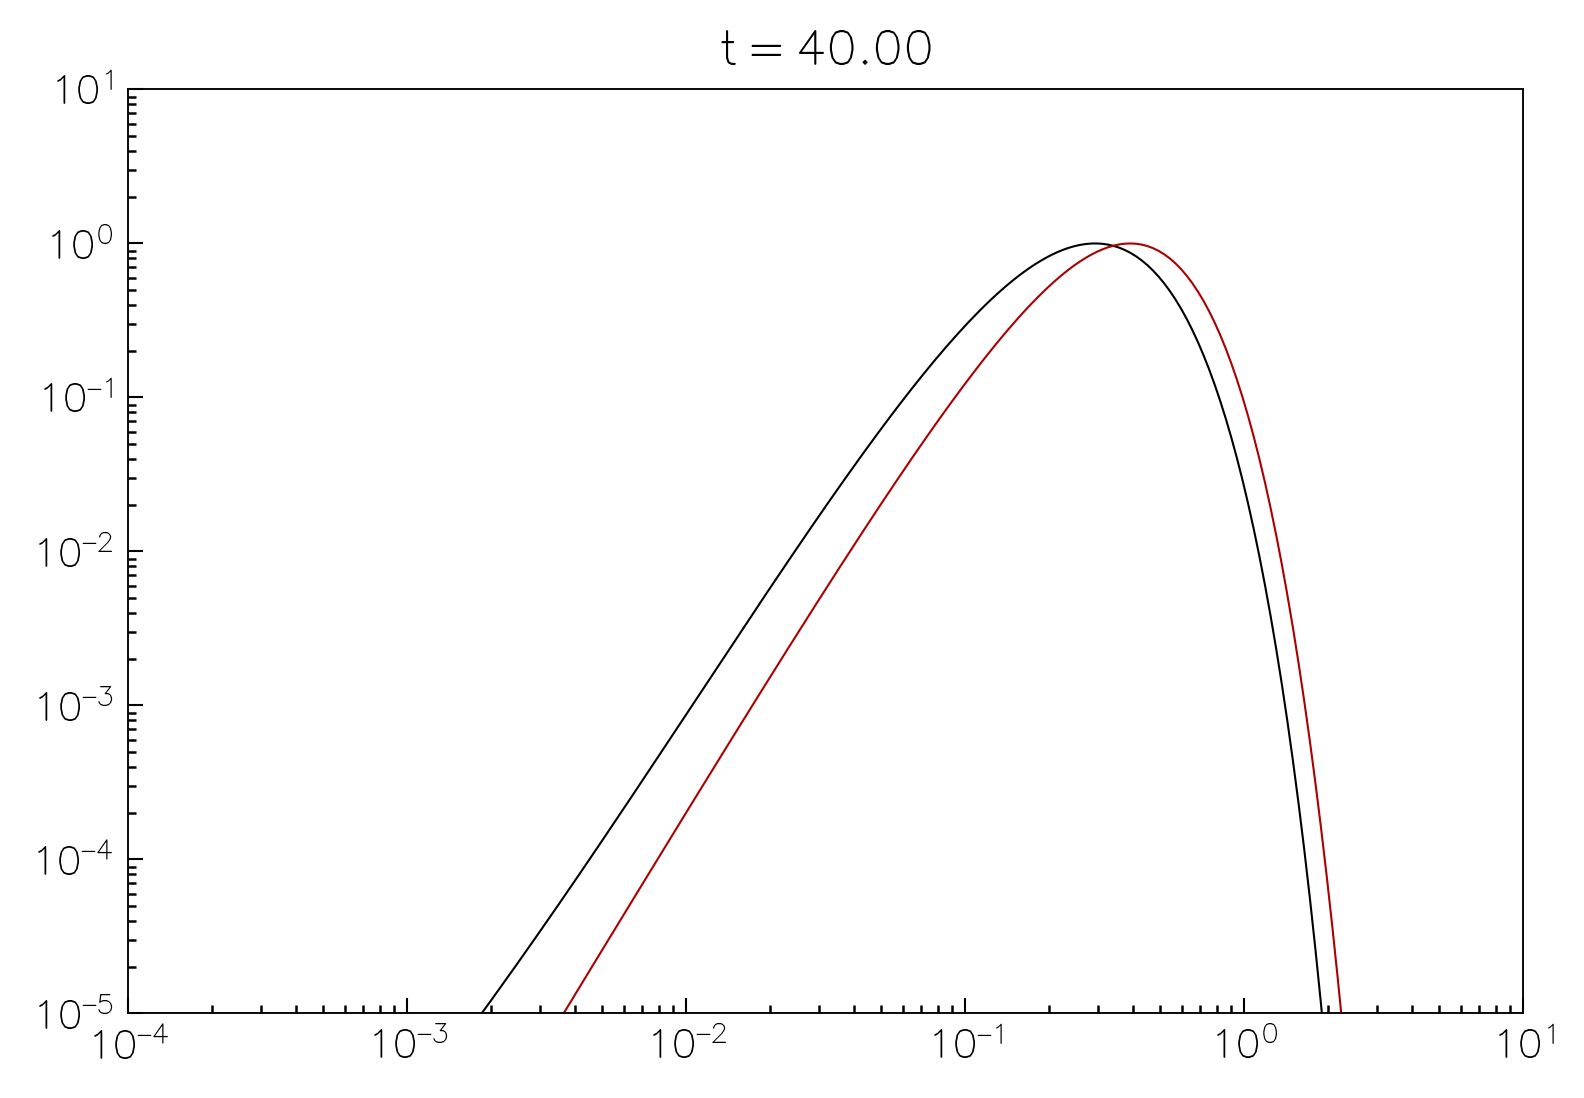

In [66]:
sim = Simulation(nx=250, engine=np, dt=2e-4, T0=0.01)
sim.Initialize()
sim.Loop(200000, 4)
sim.Plot()